In [1]:
# Importing Libraries
import os
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Base Path for all files
data_dir = 'Automobile-parts'

In [3]:
# Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 627 images belonging to 14 classes.
Found 61 images belonging to 14 classes.


In [5]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [6]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(14, activation='softmax') # 14 Output Neurons for 14 Classes
])

In [7]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [8]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 14)                14350     
                                                                 
Total params: 23,915,310
Trainable params: 2,112,526
Non-trainable params: 21,802,784
____________________________________

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [10]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [14]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 19
validation_steps : 1


In [15]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 2.2665 - accuracy: 0.3059
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to .\model_01-0.62.h5
19/19 [==============================] - 165s 8s/step - loss: 2.2665 - accuracy: 0.3059 - val_loss: 1.7236 - val_accuracy: 0.6250
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 1.4889 - accuracy: 0.6727
Epoch 2: val_accuracy improved from 0.62500 to 0.81250, saving model to .\model_02-0.81.h5
19/19 [==============================] - 149s 8s/step - loss: 1.4889 - accuracy: 0.6727 - val_loss: 1.1252 - val_accuracy: 0.8125
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 1.0130 - accuracy: 0.7849
Epoch 3: val_accuracy did not improve from 0.81250
19/19 [==============================] - 143s 7s/step - loss: 1.0130 - accuracy: 0.7849 - val_loss: 1.0042 - val_accuracy: 0.7500
Epoch 4/10
19/19 [==============================] - ETA: 0s - loss: 0.7554 - accuracy: 0.8668
Epoc

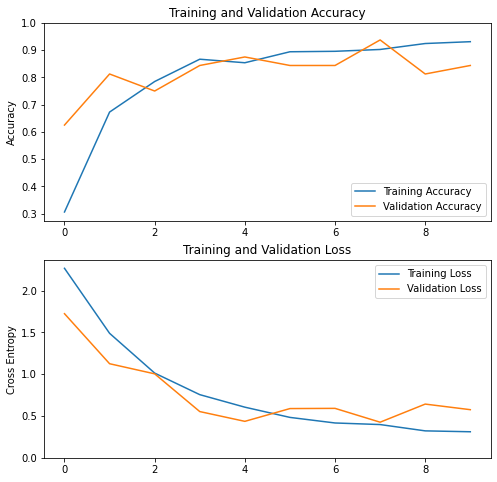

In [16]:
acc = history.history['accuracy']  # training accuracy
val_acc = history.history['val_accuracy'] # validation accuracy

loss = history.history['loss'] # training loss
val_loss = history.history['val_loss'] # validation loss

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()


In [17]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

2/2 [==============================] - 14s 7s/step - loss: 0.4519 - accuracy: 0.8689
test accuracy :  0.868852436542511


In [18]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("model_06-0.94.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Bevel-gear', 1: 'bearing', 2: 'clutch', 3: 'cylincer', 4: 'filter', 5: 'fuel-tank',
              6: 'helical_gear', 7: 'piston', 8: 'rack-pinion', 9: 'shocker', 10: 'spark-plug', 11: 'spur-gear', 
              12: 'valve', 13: 'wheel'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

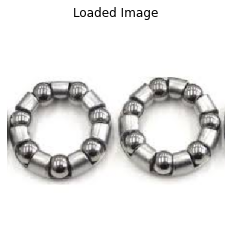

1/1 [==============================] - 4s 4s/step


Maximum Probability:  0.86212575
Classified: bearing 



-------------------Individual Probability--------------------------------

BEVEL-GEAR : 1.49 %
BEARING : 86.21 %
CLUTCH : 1.32 %
CYLINCER : 0.76 %
FILTER : 0.53 %
FUEL-TANK : 0.55 %
HELICAL_GEAR : 0.81 %
PISTON : 0.88 %
RACK-PINION : 0.3 %
SHOCKER : 1.97 %
SPARK-PLUG : 1.44 %
SPUR-GEAR : 1.45 %
VALVE : 0.75 %
WHEEL : 1.56 %


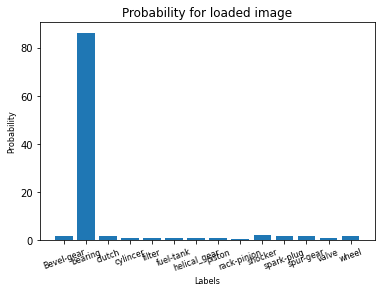

In [19]:
predict("Automobile-parts/bearing/image (71).jpg")

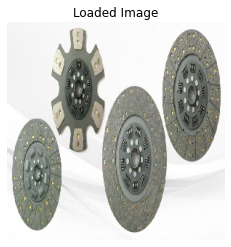

1/1 [==============================] - 0s 175ms/step


Maximum Probability:  0.96231514
Classified: clutch 



-------------------Individual Probability--------------------------------

BEVEL-GEAR : 0.08 %
BEARING : 0.34 %
CLUTCH : 96.23 %
CYLINCER : 0.12 %
FILTER : 0.12 %
FUEL-TANK : 0.18 %
HELICAL_GEAR : 0.24 %
PISTON : 0.29 %
RACK-PINION : 0.33 %
SHOCKER : 0.15 %
SPARK-PLUG : 0.16 %
SPUR-GEAR : 0.38 %
VALVE : 0.31 %
WHEEL : 1.08 %


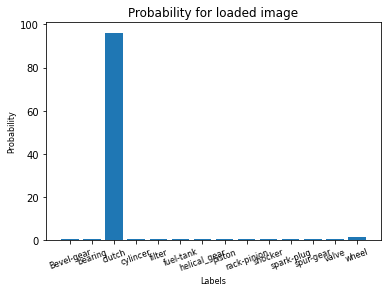

In [20]:
predict("Automobile-parts/clutch/image (103).jpg")